# Protein sensitiity

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [ ]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

## Protein sensitivity

### Calculation

In [ ]:
from bacillusme.analysis import sensitivity as ss

In [ ]:
complexes = [met.id for met in me.metabolites if isinstance(met,cobrame.Complex)]

In [ ]:
flux_results_df = ss.all_flux_responses(me,complexes[:2],mu_fix=False,solution=1,NP=10,precision=1e-6)
flux_results_df

In [ ]:
sensitivity_df,flux_results_df = ss.sensitivity(me,complexes, NP=10,solution=1)

In [ ]:
flux_results_df

biomass_dilution response (10 threads):   8%|▊         | 72/877 [1:12:29<2:34:27, 11.51s/it]  

In [6]:
cost_df,flux_results_cost_df = ss.biosynthetic_cost(me,complexes,cost_rxn='ATPM', NP=10, solution=1)


ATPM response (10 threads): 100%|██████████| 877/877 [8:21:12<00:00, 30.41s/it]

In [31]:
cost_df = cost_df.rename(columns={'sensitivity':'ATPM_response'})
sensitivity_df = sensitivity_df.rename(columns={'sensitivity':'biomass_dilution_response'})

In [34]:
flux_results_df.to_csv('./sensitivity/sensitivity_raw_results.csv')
flux_results_cost_df.to_csv('./sensitivity/cost_raw_results.csv')

sensitivity_results = sensitivity_df.join(cost_df['ATPM_response'])
sensitivity_results.to_csv('./sensitivity/sensitivity_results.csv')

### Analysis

In [33]:
flux_results_df = pd.read_csv('./sensitivity/sensitivity_raw_results.csv',index_col=0)
flux_results_cost_df = pd.read_csv('./sensitivity/cost_raw_results.csv',index_col=0)
sensitivity_results = pd.read_csv('./sensitivity/sensitivity_results.csv',index_col=0)
sensitivity_results.sort_values(by='biomass_dilution_response',ascending=False)

,molecular_weight,biomass_dilution_response,ATPM_response
CPLX8J2-124,1047.497897,1607.134663,515884.515287
CPLX8J2-24,944.132256,665.384392,204806.351190
CPLX8J2-60,372.657840,473.217001,150802.287837
BSU14630-MONOMER_mod_pydx5p,535.850563,390.213876,120067.359053
CPLX8J2-54,368.486456,375.200334,118480.984188
...,...,...,...
BSU05980-MONOMER,6.066007,4.404416,1356.242013
BSU24900-MONOMER,5.909830,4.152395,1278.367970
BSU00990-MONOMER,5.504397,3.879265,1192.969430
BSU41060-MONOMER,5.271332,3.703771,1140.139445


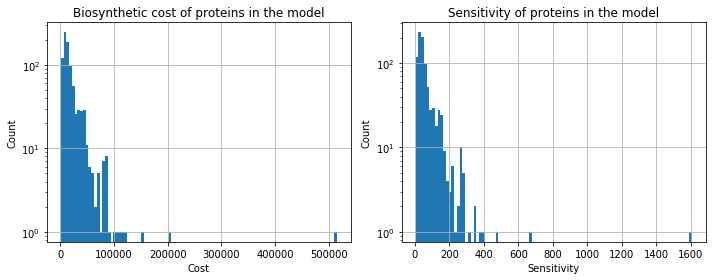

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sensitivity_results['ATPM_response'].hist(bins=100,log=True)
plt.title('Biosynthetic cost of proteins in the model')
plt.xlabel('Cost')
plt.ylabel('Count')

plt.subplot(1,2,2)
sensitivity_results['biomass_dilution_response'].hist(bins=100,log=True)
plt.title('Sensitivity of proteins in the model')
plt.xlabel('Sensitivity')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig("figures/essential_metabolite_group_KO.svg", format="SVG")

In [8]:
from sklearn.linear_model import LinearRegression

MW = sensitivity_results.dropna()['molecular_weight'].values.reshape(-1, 1)
S = sensitivity_results.dropna()['biomass_dilution_response'].dropna().values.reshape(-1, 1)
C = sensitivity_results.dropna()['ATPM_response'].dropna().values.reshape(-1, 1)
S_model = LinearRegression().fit(MW,S)
C_model = LinearRegression().fit(MW,C)
S_reg = S_model.predict(MW)
C_reg = C_model.predict(MW)

Text(0.5, 1.0, 'Correlation of S and C')

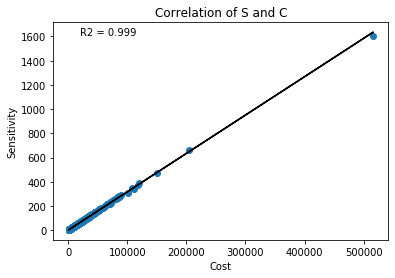

In [9]:
SC_model = LinearRegression().fit(C,S)
SC_reg = SC_model.predict(C)
plt.scatter(C,S)
plt.plot(C,SC_reg,'k')
plt.text(np.mean(C),np.max(S),'R2 = '+str(SC_model.score(C,S).round(3)))
plt.xlabel('Cost')
plt.ylabel('Sensitivity')
plt.title('Correlation of S and C')

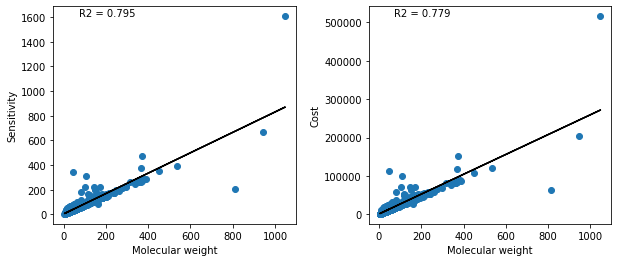

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.text(np.mean(MW),np.max(S),'R2 = '+str(S_model.score(MW,S).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

plt.subplot(1,2,2)
plt.scatter(MW,C)
plt.plot(MW,C_reg,'k')
plt.text(np.mean(MW),np.max(C),'R2 = '+str(C_model.score(MW,C).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Cost')

plt.subplots_adjust(wspace=0.3)

Text(0, 0.5, 'Residuals')

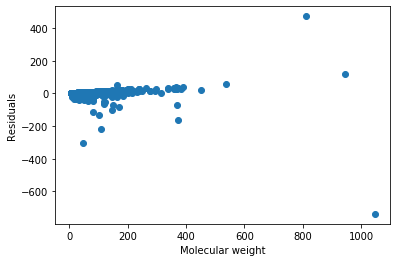

In [28]:
S_residuals = pd.DataFrame(data=S_reg-S,index=sensitivity_results.dropna().index,columns=['residuals'])
plt.scatter(MW,S_residuals.values)
plt.xlabel('Molecular weight')
plt.ylabel('Residuals')

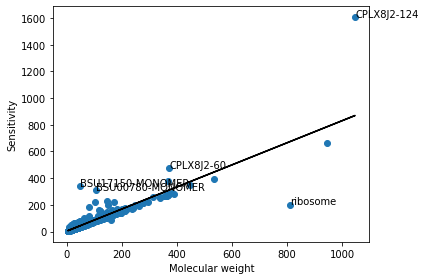

In [29]:
outliers = S_residuals.abs().sort_values(by='residuals',ascending=False).head(5).index
plt.figure()
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

for outlier_id in outliers:
    plt.text(sensitivity_results.loc[outlier_id]['molecular_weight'],
             sensitivity_results.loc[outlier_id]['biomass_dilution_response'],outlier_id)
    
plt.tight_layout()
plt.savefig("figures/protein_sensitivity_MW_correlation.svg", format="SVG")

In [30]:
for met_id in outliers.index:
    rxns = get_reactions_of_met(me,met_id,verbose=False)
    for rxn in rxns:
        if isinstance(rxn,cobrame.MetabolicReaction):
            print(met_id,rxn.subsystem)

AttributeError: 'Index' object has no attribute 'index'

In [ ]:
# Look a protein up
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
genes = ['trpE','trpD','trpC','trpF','trpB']

In [ ]:
outliers = ['BSU11190-MONOMER']
plt.figure()
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

included_genes = []
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].iteritems():
    protein_id = locus_id+'-MONOMER'
    if protein_id not in sensitivity_results.index or sensitivity_results.loc[protein_id].isnull().any():
        continue
    x, y = sensitivity_results.loc[locus_id+'-MONOMER']['molecular_weight'],\
             sensitivity_results.loc[locus_id+'-MONOMER']['biomass_dilution_response']
    plt.plot(x,y,marker='*',markersize=10,color='red')
    plt.text(x,y,gene_name)
    included_genes.append(gene_name)
plt.title(included_genes)

### Cost

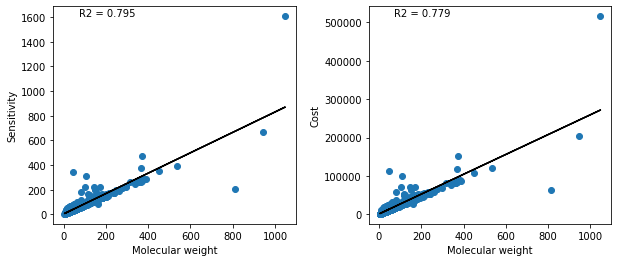

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(MW,S)
plt.plot(MW,S_reg,'k')
plt.text(np.mean(MW),np.max(S),'R2 = '+str(S_model.score(MW,S).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')

plt.subplot(1,2,2)
plt.scatter(MW,C)
plt.plot(MW,C_reg,'k')
plt.text(np.mean(MW),np.max(C),'R2 = '+str(C_model.score(MW,C).round(3)))
plt.xlabel('Molecular weight')
plt.ylabel('Cost')

plt.subplots_adjust(wspace=0.3)

Text(0, 0.5, 'Residuals')

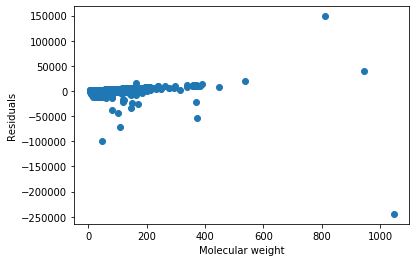

In [25]:
C_residuals = pd.DataFrame(data=C_reg-C,index=sensitivity_results.dropna().index,columns=['residuals'])
plt.scatter(MW,C_residuals.values)
plt.xlabel('Molecular weight')
plt.ylabel('Residuals')

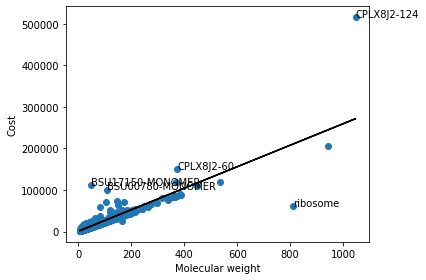

In [31]:
outliers = C_residuals.abs().sort_values(by='residuals',ascending=False).head(5).index
plt.figure()
plt.scatter(MW,C)
plt.plot(MW,C_reg,'k')
plt.xlabel('Molecular weight')
plt.ylabel('Cost')

for outlier_id in outliers:
    plt.text(sensitivity_results.loc[outlier_id]['molecular_weight'],
             sensitivity_results.loc[outlier_id]['ATPM_response'],outlier_id)
    
plt.tight_layout()
plt.savefig("figures/protein_cost_MW_correlation.svg", format="SVG")